In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import collections
import graphistry
import random

from collections import Counter

%matplotlib inline

In [2]:
source1 = 'dataset/bn-mouse-out.txt' 
source2 = 'dataset/socfb-Caltech36.txt'

graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username="klavan16", password="abcd2323")

In [3]:
# This function is used for reading the data and creating the graph.
# source: file location
# G: Graph
def create_graph(source):
    G = nx.Graph()
    with open(source) as file:
        lines = file.readlines()
        for line in lines:
            nodes = line.split()
            G.add_edge(nodes[0], nodes[1])
    return G

In [4]:
G1 = create_graph(source1)
G2 = create_graph(source2)

#### Graph Informations

In [5]:
def print_graph_info(G):
    ds = list(G.degree())
    
    print('Number of nodes: {}'.format(G.number_of_nodes()))
    print('Number of edges: {}'.format(G.number_of_edges()))
    
    degree = [int(i) for i in np.array(list(G.degree()))[:,1]]
    
    print('Max degree: {}'.format(np.max(degree)))
    print('Min degree: {}'.format(np.min(degree)))
    print('Average degree: {}'.format(np.mean(degree)))
    print('Median degree: {}'.format(np.median(degree)))

In [6]:
# people (nodes), friendship (edges).
print('\t "Graph1 information" ')
print_graph_info(G1)
print()
print('\t "Graph2 information" ')
print_graph_info(G2)

	 "Graph1 information" 
Number of nodes: 213
Number of edges: 11089
Max degree: 170
Min degree: 28
Average degree: 104.12206572769954
Median degree: 106.0

	 "Graph2 information" 
Number of nodes: 769
Number of edges: 16656
Max degree: 248
Min degree: 1
Average degree: 43.3185955786736
Median degree: 36.0


In [7]:
graphistry.bind(source='src', destination='dst', node='nodeid').plot(G1)

In [8]:
graphistry.bind(source='src', destination='dst', node='nodeid').plot(G2)

#### Graph Adjacency Matrix

In [9]:
# This function is used to show adjacency matrix
# G: Graph
# ax: for show
# title: title of the adjacency matrix 
def show_adjacency_matrix(G, ax, title):
    A = nx.to_numpy_matrix(G, dtype=np.bool)
    
    ax.set_title(title)
    ax.imshow(A, cmap="Greys", interpolation="none")

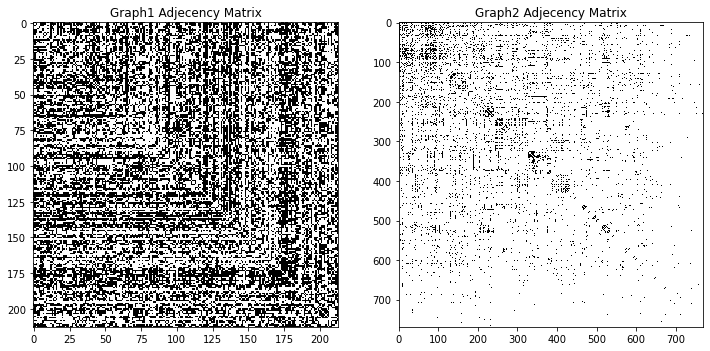

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))
show_adjacency_matrix(G1, ax1, 'Graph1 Adjecency Matrix')
show_adjacency_matrix(G2, ax2, 'Graph2 Adjecency Matrix')

#### Graph Degree Distribution

In [11]:
# This function is used to plot degree distribution
# G: Graph
# ax: for show 
# title: title of the degree distribution
def plot_degree_dist(G, ax, title):
    dfreq = np.array(nx.degree_histogram(G)).astype('float')
    x = np.array(range(len(dfreq)))
    poly = np.polyfit(x, dfreq, 15)
    poly_y = np.poly1d(poly)(x)
    ax.plot(x, poly_y)
    ax.set_title(title)
    ax.set_xlabel("Degree")
    ax.set_ylabel("Frequency")

In [12]:
# This function is used to plot degree distribution
# G1: Graph1
# G2: Graph2
# ax: for show 
# title: title of the degree distribution
def plot_degree_dist_overlay(G_list, ax, title,highlightLast = False):
    for i,G in enumerate(G_list):
        dfreq = np.array(nx.degree_histogram(G)).astype('float')
        x = np.array(range(len(dfreq)))
        poly = np.polyfit(x, dfreq, 15)
        poly_y = np.poly1d(poly)(x)
        if highlightLast and i != len(G_list)-1:
            ax.plot(x, poly_y,linestyle = ":",alpha=0.7,linewidth=0.5)
        else:
            ax.plot(x, poly_y,linestyle='-',alpha=1,linewidth=2,color= 'blue' if highlightLast else None)
        
    ax.set_title(title)
    ax.set_xlabel("Degree")
    ax.set_ylabel("Frequency")

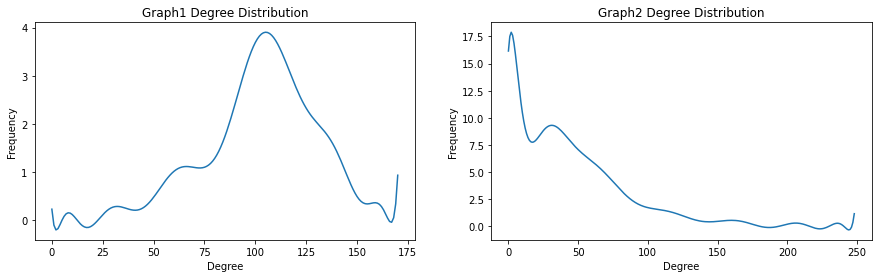

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
plot_degree_dist(G1, ax1, 'Graph1 Degree Distribution')
plot_degree_dist(G2, ax2, 'Graph2 Degree Distribution')

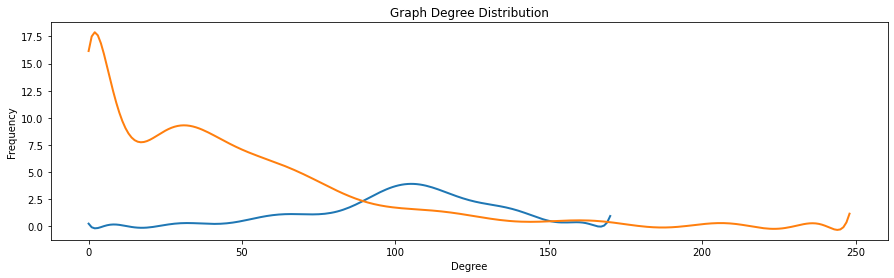

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
G_list = [G1, G2]
plot_degree_dist_overlay(G_list, ax, 'Graph Degree Distribution')

#### Random graph generation with given degree distribution

In [15]:
def get_degrees(G):
    degrees = [val for (node, val) in G.degree()]
    return degrees

In [16]:
def generate_random_graph(degrees, N):
    G_list = []
    
    for i in range(N):
        G = nx.expected_degree_graph(degrees, selfloops=False)
        G_list.append(G)
    return G_list

In [17]:
N = 100

In [18]:
degrees1 = get_degrees(G1)
G_list1 = generate_random_graph(degrees1, N)
G_list1.append(G1)

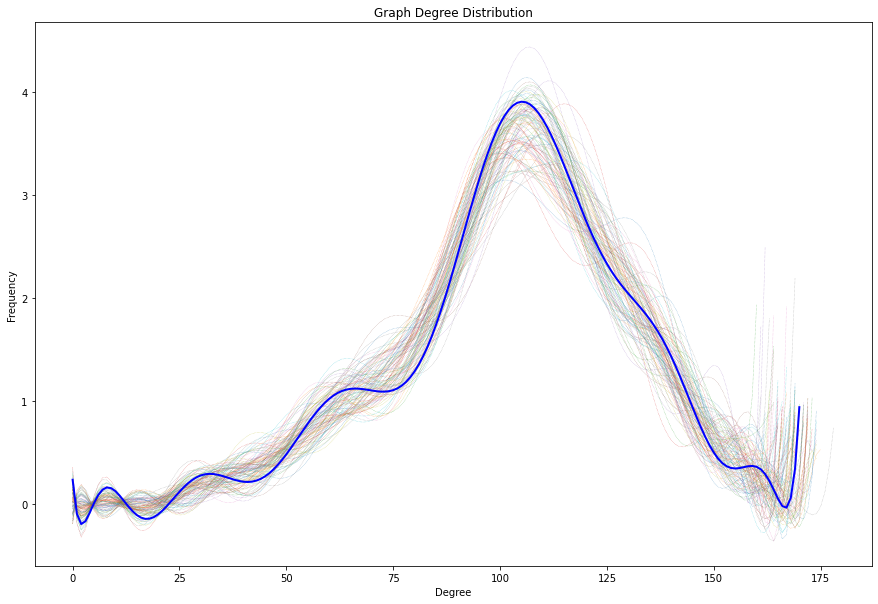

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plot_degree_dist_overlay(G_list1[:], ax, 'Graph Degree Distribution',True)

In [20]:
degrees2 = get_degrees(G2)
G_list2 = generate_random_graph(degrees2, N)
G_list2.append(G2)

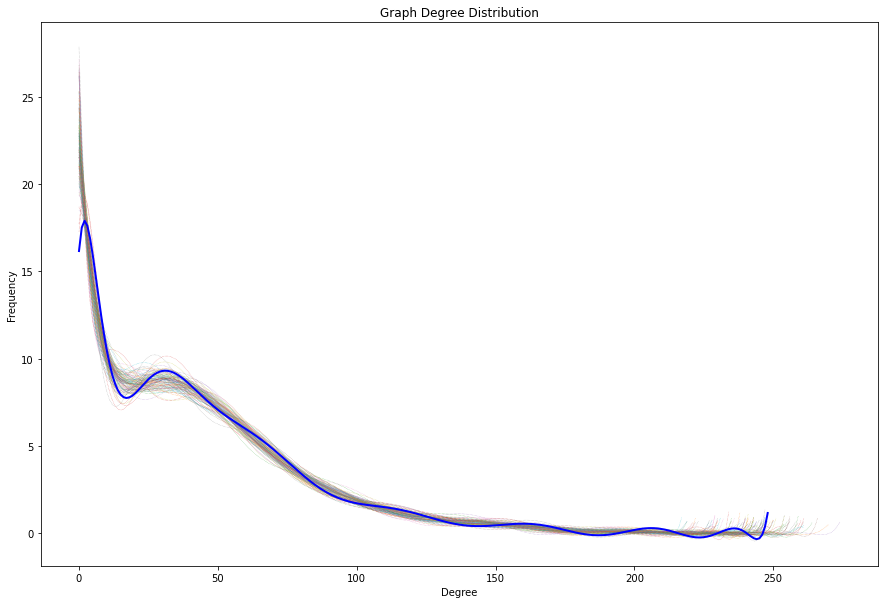

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plot_degree_dist_overlay(G_list2[:], ax, 'Graph Degree Distribution',True)

#### Rich club

In [22]:
# n: number of nodes
# p: random probability
def erdos_renyi(n, p):
    G = nx.Graph()
    
    G.add_nodes_from(set([i for i in range(n)]))
    
    for i in range(n):
        for j in range(n):
            if i != j and i < j:
                x = random.random()
                if x < p:
                    G.add_edge(i, j)
    return G

In [23]:
G3 = erdos_renyi(50, 0.33)
G4 = erdos_renyi(50, 0.66)

In [24]:
# This function is used to plot rich club coefficient
# G: Graph
# ax: for show
def plot_rc_coefficient(G, ax):
    dict_ = {}
    rcc = nx.rich_club_coefficient(G, normalized=False)
    
    keys = np.array(list(rcc.keys()))
    values = np.array(list(rcc.values()))
    
    poly = np.polyfit(keys, values, 15)
    poly_y = np.poly1d(poly)(keys)

    ax.plot(keys, poly_y)
    ax.set_xlabel("Node Degree")
    ax.set_ylabel("Average Rich Club Coefficient")

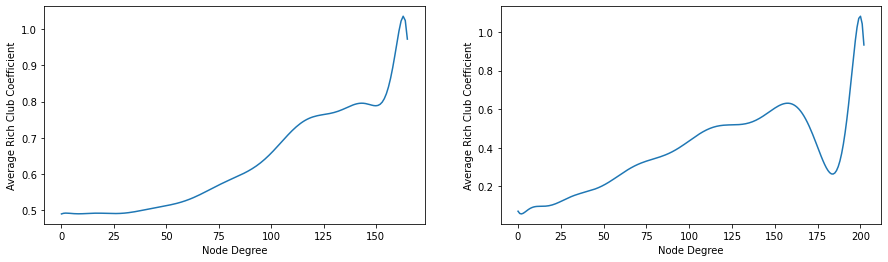

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
plot_rc_coefficient(G1, ax1)
plot_rc_coefficient(G2, ax2)

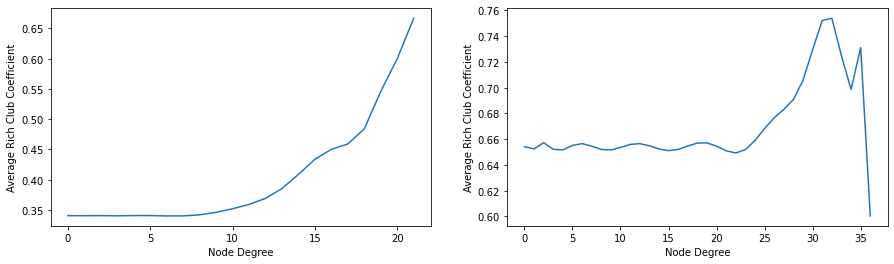

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
plot_rc_coefficient(G3, ax1)
plot_rc_coefficient(G4, ax2)

#### Average Thresholded Rich Club Node Rate

While the maximum rich club value a node can get is 1, the minimum rich club value is 0. The average of these two values is 0.5. This value has been chosen as the average threshold value. Rich club values below this threshold value selected are not included in the calculation. This value is obtained by dividing the number of these nodes above the threshold value by the number of all nodes.

In [27]:
def thresh_rc_node_rate(G, thresh):
    rcc = nx.rich_club_coefficient(G, normalized=False)
    
    cnt = 0
    for node in list(G.nodes):
        degree = G.degree[node]
        
        if degree in rcc:
            if thresh < rcc[degree]:
                cnt += 1
        else:
            cnt += 1
    
    return cnt / G.number_of_nodes()

In [28]:
thresh = 0.5

In [29]:
node_rate1 = thresh_rc_node_rate(G1, thresh)
node_rate2 = thresh_rc_node_rate(G2, thresh)

0.9906103286384976
0.05071521456436931
